In [ ]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.linear_model import Lasso
import re
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import *

CPU times: user 68 µs, sys: 9 µs, total: 77 µs
Wall time: 82.3 µs


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%%time
accepted = pd.read_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/accepted_2007_to_2018q4.csv/accepted.csv", low_memory = False)
features = pd.read_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/features.csv", low_memory = False)
#rejected = pd.read_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv", low_memory = False)

CPU times: user 1min 37s, sys: 12.4 s, total: 1min 49s
Wall time: 2min 28s


In [ ]:
print(accepted.shape)
#print(rejected.shape)

(2260668, 166)


In [ ]:
accepted.head()

In [ ]:
accepted.info(max_cols = 160)

In [ ]:
accepted.info()

In [ ]:
accepted.describe()

In [ ]:
rejected.info()

In [ ]:
rejected.describe()

In [ ]:
plt.figure(figsize = (15,15))
correlation_matrix = rejected.corr()
sns.heatmap(correlation_matrix, annot = True)
plt.show()

In [ ]:
plt.figure(figsize = (25,15))
sns.boxplot(accepted.grade, accepted.loan_amnt)

In [ ]:
plt.figure(figsize = (25,15))
sns.boxplot(accepted.grade, accepted.annual_inc_joint)

In [ ]:
accepted_missing = pd.DataFrame(accepted.isnull().mean(axis = 0).sort_values(ascending = False), 
                                columns = ["Num_Missing"])
                                #index = accepted.columns)
#accepted_missing.Num_Missing = accepted_missing.Num_Missing/accepted.shape[0]

In [ ]:
accepted_missing.head()

In [ ]:
# accepted = accepted.drop(columns = ['sec_app_chargeoff_within_12_mths',
#                                     'sec_app_fico_range_high',
#                                     'sec_app_inq_last_6mths',
#                                     'sec_app_mort_acc',
#                                     'sec_app_open_acc',
#                                     'sec_app_revol_util',
#                                     'sec_app_open_act_il',
#                                     'sec_app_num_rev_accts',
#                                     'sec_app_fico_range_low',
#                                     'sec_app_collections_12_mths_ex_med',
#                                     'sec_app_mths_since_last_major_derog',
#                                     'sec_app_earliest_cr_line',
#                                     'revol_bal_joint',
#                                     'member_id'],
#                                     axis =  1)
accepted.info(max_cols = 200)

In [ ]:
accepted_missing[accepted_missing["Num_Missing"] > 0.5]

In [ ]:
date = []
for x in accepted.columns:
    if re.findall("date", x):
        date.append(x)
date

In [ ]:
# %%time
# for i in range(len(accepted.term)):
#     if accepted.term[i]:
#         accepted.term[i] = int(re.sub(pattern = "(\d\d)*([^\d])*", repl = r"\1", string = accepted.term[i]))

In [ ]:
# #list(map(lambda i: int(re.sub(pattern = "(\d\d)*([^\d])*", \
#                               repl = r"\1", \
#                               string = accepted.term[i])) \
#                        if accepted.term[i] for i in range(len(accepted.term)), 
#          accepted.term))

In [ ]:
%%time
accepted["term"] = accepted["term"].apply(lambda term: int(re.sub(pattern = "(\d\d)*([^\d])*", repl = r"\1", string = term)) if isinstance(term, str) else term)

In [ ]:
# Our target variable
accepted["total_payment"] = accepted.installment * accepted.term

In [ ]:
accepted[accepted.term.isnull()]

In [ ]:
accepted = accepted.dropna(axis = 0, how = "any", subset = ["term"])

In [ ]:
accepted[accepted.term.isnull()]

In [ ]:
#%%time
#accepted.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/accepted_2007_to_2018q4.csv/accepted.csv")

In [ ]:
hardship = accepted[accepted.hardship_status.notnull()]
hardship

In [ ]:
type(hardship)

In [ ]:
hardship.hardship_reason.unique()

In [ ]:
#plt.figure(figsize = (20,20))
sns.boxplot(x = hardship.hardship_reason,
            y = hardship.hardship_length,
            data = hardship)

In [ ]:
len(hardship.hardship_length.unique())

In [ ]:
len(accepted.hardship_length.unique())

In [ ]:

[math.isnan(val) for val in accepted.hardship_length.unique()]

In [ ]:
%%time
accepted["hardship_length"] = accepted["hardship_length"].apply(lambda entry: 0 if math.isnan(entry) else entry)

In [ ]:
accepted[accepted.hardship_length.isnull()]

In [ ]:
plt.figure(figsize = (20,20))
sns.boxplot(x = hardship.hardship_reason,
            y = hardship.total_payment,
            data = hardship)

In [ ]:
accepted.drop(["member_id"], axis = 1, inplace = True)

In [ ]:
accepted_missing

In [ ]:
hardship.hardship_status.unique()

In [ ]:
print(np.mean(hardship.hardship_status == 'COMPLETED'))
print(np.mean(hardship.hardship_status == 'ACTIVE'))
print(np.mean(hardship.hardship_status == 'BROKEN'))

In [ ]:
# plt.figure(figsize = (20,20))
# sns.barplot(x = hardship.hardship_reason,
#             y = sum(hardship.hardship_status == 'COMPLETED'),
#             data = hardship)

In [ ]:
print(sum(hardship.hardship_status == 'COMPLETED'))
print(sum(hardship.hardship_status == 'ACTIVE'))
print(sum(hardship.hardship_status == 'BROKEN'))

In [ ]:
sum(accepted.issue_d.isnull())

In [ ]:
len(accepted.issue_d.unique())

In [ ]:
accepted.issue_d.unique()

In [ ]:
%%time
accepted["issue_d"] = accepted["issue_d"].apply(lambda date: re.sub(pattern = "([A-Za-z]*)([-])*([0-9]*)", repl = r"\1\3", string = date) if isinstance(date, str) else date)

In [ ]:
accepted["issue_d"] = pd.to_datetime(accepted.issue_d, 
                                     format = "%Y-%m-%d", 
                                     #errors = "ignore", 
                                     yearfirst = True)
accepted.issue_d

In [ ]:
accepted.issue_d.unique()

In [ ]:
plt.figure(figsize = (15,10))
count_by_year = pd.DataFrame(accepted.groupby(["issue_d"])["id"].count())
print(count_by_year)
sns.lineplot(count_by_year.index, count_by_year.id, data = count_by_year)

In [ ]:
accepted.purpose.unique()

In [ ]:
plt.figure(figsize = (20,10))
count_by_purpose = pd.DataFrame(accepted.groupby(["purpose"])["id"].count().sort_values())
count_by_purpose
sns.barplot(count_by_purpose.index, count_by_purpose.id, palette = "deep")

In [ ]:
count_by_purpose = count_by_purpose.sort_values(by = "id", ascending = False).reset_index()

In [ ]:
count_by_purpose = count_by_purpose.rename(columns = {"id":"count"})
#count_by_purpose.drop("index", axis = 1, inplace = True)
count_by_purpose

In [ ]:
count_by_purpose["count"] = count_by_purpose["count"] / sum(count_by_purpose["count"])
count_by_purpose

In [ ]:
count_by_purpose_grade = pd.DataFrame(accepted.groupby(["purpose", "grade"])["id"].count())
count_by_purpose_grade.reset_index(inplace = True)
count_by_purpose_grade

In [ ]:
plt.figure(figsize = (30,6))
#count_by_purpose_grade.index
sns.barplot(count_by_purpose_grade.index, 
            count_by_purpose_grade.id, 
            order = count_by_purpose_grade.sort_values(by = "id", ascending = False, inplace = False).index)
ind = range(len(count_by_purpose_grade))
labels = list(zip(count_by_purpose_grade.purpose, count_by_purpose_grade.grade))
plt.xticks(ind, labels, rotation = 90)
plt.show()

In [ ]:
list(zip(count_by_purpose_grade.purpose, count_by_purpose_grade.grade))

In [ ]:
accepted["year"] = pd.DatetimeIndex(accepted.issue_d).year
accepted["year"]

In [ ]:
count_by_purpose_year = pd.DataFrame(accepted.groupby(["year","purpose"])["id"].count())
count_by_purpose_year.reset_index(inplace = True)
count_by_purpose_year

In [ ]:
plt.figure(figsize = (30,6))

sns.barplot(count_by_purpose_year.index, 
            count_by_purpose_year["id"],
            order = count_by_purpose_year.sort_values(by = "id", ascending = False, inplace = False).index)

ind = range(len(count_by_purpose_year))
labels = list(zip(count_by_purpose_year.year, count_by_purpose_year.purpose))
plt.xticks(ind, labels, rotation = 90)

plt.show()

In [ ]:
count_by_purpose_year_grade = pd.DataFrame(accepted.groupby(["issue_year","purpose", "grade"])["id"].count())
count_by_purpose_year_grade.reset_index(inplace = True)
#count_by_purpose_year_grade.rename(columns = {"id":"total"})

In [ ]:
count_by_purpose_year_grade = count_by_purpose_year_grade.sort_values(by = "id", ascending = False, inplace = False).reset_index()
count_by_purpose_year_grade.drop("index", axis = 1, inplace = True)

In [ ]:
count_by_purpose_year_grade.describe()

In [ ]:
#pd.options.display.max_rows = None
top = count_by_purpose_year_grade[count_by_purpose_year_grade["id"] > 1e4]
top

In [ ]:
plt.figure(figsize = (30,8))

sns.barplot(top.index, top["id"])

ind = range(len(top))
labels = list(zip(top.issue_year, top.purpose, top.grade))
plt.xticks(ind, labels, rotation = 90)

plt.show()

In [ ]:
accepted.purpose.unique()

In [ ]:
med_fund = pd.DataFrame(accepted.groupby("purpose")["funded_amnt"].median().sort_values(ascending = False))
med_fund = med_fund.reset_index()
med_fund = med_fund.rename(columns = {"funded_amnt":"median_funded"})
med_fund 

In [ ]:
mean_funded = pd.DataFrame(accepted.groupby("purpose")["funded_amnt"].mean().sort_values(ascending = False))
mean_funded = mean_funded.reset_index()
mean_funded = mean_funded.rename(columns = {"funded_amnt":"mean_amount"})
mean_funded

In [ ]:
mean_funded["mean_amount"] = mean_funded["mean_amount"].apply(round)
mean_funded


In [ ]:
pd.DataFrame(accepted.groupby(["grade", "purpose"])["total_payment", "delinq_amnt"].agg("median", "mean")).sort_values("total_payment", ascending = False).reset_index()

In [ ]:
delinq_total = pd.DataFrame(accepted.groupby(["grade", "purpose"])["total_payment", "delinq_amnt"].mean()).sort_values("delinq_amnt", ascending = False).reset_index()
delinq_total

In [ ]:
plt.figure(figsize = (20,10))

sns.scatterplot(delinq_total.delinq_amnt,
                delinq_total.total_payment)

plt.show()

In [ ]:
plt.figure(figsize = (20,10))

sns.scatterplot(delinq_total.delinq_amnt,
                np.log(delinq_total.total_payment))

plt.show()

In [ ]:
accepted.head()

In [ ]:
#%%time
#accepted.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/accepted_2007_to_2018q4.csv/accepted.csv")

In [ ]:
len(accepted.sub_grade.unique())

In [ ]:
accepted.shape

In [ ]:
grade_int_rate = pd.DataFrame(accepted.groupby("grade")["int_rate"].mean()).sort_values(by = "int_rate", ascending = False).reset_index()
grade_int_rate.int_rate = round(grade_int_rate.int_rate)
grade_int_rate

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = accepted.grade,
            y = accepted.int_rate,
            order = ["G", "F", "E", "D", "C", "B", "A"])

plt.show()

# Number of outliers seems to decrease with the quality of the loan 
# Higher quality loans are much more selective

In [ ]:
subgrade_intrate = pd.DataFrame(accepted.groupby("sub_grade")["int_rate"].mean()).sort_values(by = "int_rate", ascending = False).reset_index()
subgrade_intrate.int_rate = round(subgrade_intrate.int_rate, 1)
subgrade_intrate

In [ ]:
lst = ["d5", "d6", "d1"]
sorted(lst)

In [ ]:
sorted(subgrade_intrate.sub_grade)

In [ ]:
%time
plt.figure(figsize = (25,10))

sns.boxplot(x = accepted.sub_grade,
            y = accepted.int_rate,
            order = sorted(accepted.sub_grade.unique(), reverse = True))

plt.show()

In [ ]:
np.mean(accepted.term == accepted.term.apply(int))

In [ ]:
accepted.term = accepted.term.apply(int)

In [ ]:
grade_term_rate = pd.DataFrame(accepted.groupby(["grade", "term"])["int_rate"].mean()).sort_values(by = "int_rate", ascending = False).reset_index()
grade_term_rate.int_rate = round(grade_term_rate.int_rate, 2)
grade_term_rate

In [ ]:
pd.DataFrame(accepted.groupby(["grade", "term"])["int_rate"].median()).sort_values(by = "int_rate", ascending = False).reset_index()

In [ ]:
pd.options.display.max_rows = None
pd.DataFrame(accepted.groupby(["sub_grade", "term"])["int_rate"].mean()).sort_values(by = "int_rate", ascending = False).reset_index()

In [ ]:
pd.DataFrame(accepted.groupby(["sub_grade", "term"])["int_rate"].median()).sort_values(by = "int_rate", ascending = False).reset_index()

In [ ]:
accepted.term.unique()

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = accepted.term,
            y = accepted.int_rate)

plt.show()

In [ ]:
pd.DataFrame(accepted.groupby("year")["int_rate"].mean()).sort_values(by = "int_rate", ascending = False).reset_index()

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = accepted.year,
            y = accepted.int_rate,
            order = sorted(accepted.year.unique()))

plt.show()

In [ ]:
%time

plt.figure(figsize = (30,10))

sns.lineplot(x = accepted.issue_year,
            y = accepted.int_rate)

plt.show()

In [ ]:
count_by_year = pd.DataFrame(accepted.groupby(["issue_year"])["id"].count()).sort_values(by = "id", ascending = False).reset_index()
count_by_year = count_by_year.rename(columns = {"id":"count"})
count_by_year


In [ ]:
year_purpose = pd.DataFrame(accepted.groupby(["issue_year", "purpose"])["id"].count()).sort_values(by = "id", ascending = False).reset_index()
house_trend = year_purpose[year_purpose.purpose == "house"].reset_index()
house_trend.drop(["index", "purpose"], axis = 1, inplace  = True)
house_trend = house_trend.rename(columns = {"id":"count"})
house_trend["count"] = house_trend["count"]/count_by_year["count"]
house_trend

In [ ]:
plt.figure(figsize = (30,10))

sns.barplot(x = house_trend.issue_year,
            y = house_trend["count"],
            palette = "icefire")

plt.xticks(fontsize = 15)
plt.title(" Total Proportion of \n  Housing Loans by Year ", fontsize = 40)
plt.show()

In [ ]:
accepted.loan_status.unique()

In [ ]:
status_count =  pd.DataFrame(accepted.groupby("loan_status")["id"].count()).sort_values(by = "id", ascending = False).reset_index()
status_count.id = round(100 * status_count.id/sum(status_count.id), 3)
status_count = status_count.rename(columns = {"id":"percentage"})
status_count

In [ ]:
accepted.settlement_status.unique()

In [ ]:
settlement_count = pd.DataFrame(accepted.groupby(["grade", "settlement_status", "term"])["id"].count())#.sort_values(by = "id", ascending = False).reset_index()
settlement_count.id = round(100 *  settlement_count.id / sum(settlement_count.id),3) 
settlement_count = settlement_count.rename(columns = {"id":"percentage"})
settlement_count

In [ ]:
#pd.options.display.max_rows = 10
accepted.last_pymnt_d

In [ ]:
# %time
# accepted.last_pymnt_d = accepted.last_pymnt_d.apply(lambda date: re.sub(pattern = "-", repl = "", string = date) if isinstance(date, str) else date)
# accepted.last_pymnt_d

In [ ]:
accepted.last_pymnt_d = pd.to_datetime(accepted.last_pymnt_d,
                                       format = "%Y%m%d",
                                       yearfirst = True)

accepted.last_pymnt_d

In [ ]:
accepted = accepted.rename(columns = {"year":"issue_year"})
accepted.issue_year

In [ ]:
accepted.issue_d = pd.to_datetime(accepted.issue_d,
                                  yearfirst = True,
                                  format = "%Y-%m-%d")

accepted.issue_d

In [ ]:
accepted["loan_duration"] = accepted.last_pymnt_d - accepted.issue_d
accepted["loan_duration"] = accepted["loan_duration"].apply(lambda x: x.days)
accepted["loan_duration"]

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = accepted.loan_status,
            y = accepted.loan_duration)

plt.show()

In [ ]:
# %%time
# (accepted.last_pymnt_d - accepted.issue_d).apply(lambda date: re.sub(pattern = "([\d]{0,4})([^\n]*)", repl = r"\1", string = str(date)) if isinstance(str(date), str) \
#                                                 else  re.sub(pattern = ".*", repl = r"0", string = date)).apply(lambda x: int(x) if x != "" else x)

In [ ]:
sum(accepted.loan_duration.isnull())

In [ ]:
# %%time
# accepted.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/accepted_2007_to_2018q4.csv/accepted.csv")

In [ ]:
(accepted.last_pymnt_d - accepted.issue_d).apply(lambda x: x.days)

In [ ]:
accepted.loan_status.unique()

In [ ]:
def function(x):
    if x in ['Late (31-120 days)', 'Late (16-30 days)']:
        return "Late"
    elif x == 'Does not meet the credit policy. Status:Charged Off':
        return "Charged Off"
    elif x == 'Does not meet the credit policy. Status:Fully Paid':
        return "Fully Paid"
    else:
        return x

In [ ]:
accepted.loan_status.apply(function).unique()

In [ ]:
accepted["loan_status_trim"] = accepted.loan_status.apply(function)
accepted.loan_status_trim

In [ ]:
'Late (31-120 days)' in ['Late (31-120 days)', 'Late (16-30 days)']

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = accepted.loan_status_trim,
            y = accepted.loan_duration)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = accepted.loan_status_trim,
            y = accepted.loan_duration/30)

plt.title("Distribution of Loan Duration \n by Loan Status", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("Loan Duration in Months", fontsize = 20)
plt.xlabel("Loan Status", fontsize = 20)

plt.show()

In [ ]:
%%time

plt.figure(figsize = (30,10))

sns.violinplot(x = accepted.loan_status_trim,
            y = accepted.loan_duration/30)

plt.title("Distribution of Loan Duration \n by Loan Status", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("Loan Duration in Months", fontsize = 20)
plt.xlabel("Loan Status", fontsize = 20)

plt.show()

In [ ]:
pd.options.display.max_rows = None
pd.DataFrame(accepted.groupby(["loan_status_trim", "term"])["loan_duration"].median())

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = accepted.grade,
               y = accepted.loan_duration/30,
               order = sorted(accepted.grade.unique()))

plt.title("Distribution of Loan Duration \n by Loan Status", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("Loan Duration in Months", fontsize = 20)
plt.xlabel("Loan Status", fontsize = 20)

plt.show()

In [ ]:
grade_term_duration = pd.DataFrame(accepted.groupby(["grade", "term"])["loan_duration"]).reset_index()
grade_term_duration

In [ ]:
pd.options.display.max_rows = 10

grade_term_duration.drop("index", inplace = True, axis = 1)

In [ ]:
grade_term_duration = pd.DataFrame(accepted.groupby(["grade", "term"])["loan_duration"], columns = ["Grade_Term", "Loan_Duration"])
grade_term_duration

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = grade_term_duration.Grade_Term,
            y = accepted.loan_duration/30)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = accepted.term,
            y = accepted.loan_duration/30)

plt.show()

In [ ]:
term36 = accepted[accepted.term == 36.0]
term36

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = term36.grade,
               y = term36.loan_duration/30,
               order = sorted(term36.grade.unique()))

plt.title("Duration of 36-Month Loans \n by Loan Grade", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Loan Duration (Months)", fontsize = 20)

plt.show()

In [ ]:
term36_fullypaid = accepted.loc[(accepted.term == 36) & (accepted.loan_status == "Fully Paid")]
term36_fullypaid

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = term36_fullypaid.grade,
               y = term36_fullypaid.loan_duration/30,
               order = sorted(term36_fullypaid.grade.unique()))

plt.show()

In [ ]:
# Why do more loans in the lower grades get paid off earlier than the higher grades?
# Higher interest rates put more pressure on the borrower?
# Average loan amounts differ?

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = term36_fullypaid.grade,
               y = term36_fullypaid.int_rate,
               order = sorted(term36_fullypaid.grade.unique()))

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = term36_fullypaid.grade,
               y = term36_fullypaid.total_payment,
               order = sorted(term36_fullypaid.grade.unique()))

plt.title("Total Value of Fully Paid \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Installment times Term", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = term36_fullypaid.grade,
               y = term36_fullypaid.total_payment,
               order = sorted(term36_fullypaid.grade.unique()))

plt.title("Total Value of Fully Paid \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Installment times Term", fontsize = 20)

plt.show()

#The total value is inflated by the varied interest rates, therefore this can be misleading

In [ ]:
term60_fullypaid = accepted.loc[(accepted.term == 60) & (accepted.loan_status == "Fully Paid")]
term60_fullypaid

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = term60_fullypaid.grade,
               y = term60_fullypaid.loan_duration/30,
               order = sorted(term36_fullypaid.grade.unique()))

plt.title("Loan Duration for \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Loan Duration (Months)", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = term60_fullypaid.grade,
               y = term60_fullypaid.loan_amnt,
               order = sorted(term60_fullypaid.grade.unique()))

plt.title("Loan Amount for \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Loan Amount (US$)", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = term36_fullypaid.grade,
               y = term36_fullypaid.loan_amnt,
               order = sorted(term36_fullypaid.grade.unique()))

plt.title("Loan of Fully Paid \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Loan Amount", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = term36_fullypaid.grade,
               y = term36_fullypaid.loan_amnt,
               order = sorted(term36_fullypaid.grade.unique()))

plt.title("Loan Amount of Fully Paid \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Loan Amount", fontsize = 20)

plt.show()

Profitability of the loan (Fully Paid): (total_pymnt - loan_amnt) / loan_amnt

Gives percentage of principal returned as profit

In [ ]:
# Return on investment
term36_fullypaid["return_36"] = 1 + ((term36_fullypaid.total_pymnt - term36_fullypaid.loan_amnt) / term36_fullypaid.loan_amnt)
term60_fullypaid["return_60"] = 1 + ((term60_fullypaid.total_pymnt - term60_fullypaid.loan_amnt) / term60_fullypaid.loan_amnt)
print(term36_fullypaid.return_36)
print(term60_fullypaid.return_60)

In [ ]:
plt.figure(figsize = (30,10))

sns.boxenplot(x = term36_fullypaid.grade,
              y = term36_fullypaid.return_36,
              order = sorted(term36_fullypaid.grade.unique()),
              palette = "Blues")

plt.title("Profit Percentage of Fully Paid \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.boxenplot(x = term60_fullypaid.grade,
              y = term60_fullypaid.return_60,
              order = sorted(term36_fullypaid.grade.unique()),
              palette = "YlOrBr")

plt.title("Profit Percentage of Fully Paid \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
# %%time
# accepted.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/accepted_2007_to_2018q4.csv/accepted.csv")

In [ ]:
term36_default_chargedoff = accepted.loc[(accepted.term == 36) & ((accepted.loan_status_trim == "Default") | (accepted.loan_status_trim == "Charged Off"))]
term36_default_chargedoff

In [ ]:
term36_default_chargedoff["profit"] = 1 + ((term36_default_chargedoff.total_pymnt - term36_default_chargedoff.loan_amnt) / term36_default_chargedoff.loan_amnt)

In [ ]:
plt.figure(figsize = (30,10))

sns.boxenplot(x = term36_default_chargedoff.grade,
              y = term36_default_chargedoff.profit,
              order = sorted(term36_default_chargedoff.grade.unique()),
              palette = "YlOrBr")

plt.title("Profit Percentage of \n Default or Charged Off \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
term60_default_chargedoff = accepted.loc[(accepted.term == 60) & ((accepted.loan_status_trim == "Default") | (accepted.loan_status_trim == "Charged Off"))]
term60_default_chargedoff

In [ ]:
term60_default_chargedoff["profit"] = 1 + ((term60_default_chargedoff.total_pymnt - term60_default_chargedoff.loan_amnt) / term60_default_chargedoff.loan_amnt)

In [ ]:
plt.figure(figsize = (30,10))

sns.boxenplot(x = term60_default_chargedoff.grade,
              y = term60_default_chargedoff.profit,
              order = sorted(term60_default_chargedoff.grade.unique()),
              palette = "Greens")

plt.title("Profit Percentage of \n Default or Charged Off \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = term36_default_chargedoff.grade,
               y = term36_default_chargedoff.loan_amnt,
               order = sorted(term36_default_chargedoff.grade.unique()))

plt.title("Loan Amount of \n Default or Charged Off \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Loan Amount", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = term60_default_chargedoff.grade,
               y = term60_default_chargedoff.loan_amnt,
               order = sorted(term60_default_chargedoff.grade.unique()))

plt.title("Loan Amount of \n Default or Charged Off \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Loan Amount", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = term36_fullypaid.grade,
               y = term36_fullypaid.annual_inc_joint,
               order = sorted(term36_fullypaid.grade.unique()))

plt.title("Annual Joint Income of \n Fully Paid \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Annual Joint Income (Millions)", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(x = term36_fullypaid.grade,
               y = term36_fullypaid.annual_inc_joint,
               order = sorted(term36_fullypaid.grade.unique()))

plt.title("Annual Joint Income of \n Fully Paid \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Annual Joint Income (Millions)", fontsize = 20)

plt.show()

In [ ]:
np.mean(accepted.annual_inc_joint.isnull())

In [ ]:
accepted[["annual_inc", "annual_inc_joint"]]

In [ ]:
np.mean(accepted.annual_inc == accepted.annual_inc_joint)

Impute missing values in Annual Joint Income (annual_inc_joint)
If missing, impute annual_inc

In [ ]:
math.isnan(accepted.annual_inc_joint[0])

In [ ]:
# %%time
# accepted["annual_inc_joint"] = accepted[["annual_inc", "annual_inc_joint"]].apply(max, axis = 1)
# accepted["annual_inc_joint"]

In [ ]:
# %%time
# accepted.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/accepted_2007_to_2018q4.csv/accepted.csv")

In [ ]:
terminated36 = accepted.loc[(accepted.term == 36) & ((accepted.loan_status == "Default") | (accepted.loan_status == "Charged Off") | (accepted.loan_status == "Fully Paid"))]
terminated36

In [ ]:
terminated36["profit"] = 1 + ((terminated36.total_pymnt - terminated36.loan_amnt) / terminated36.loan_amnt)
terminated36["profit"]

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = terminated36.grade,
              y = terminated36.profit,
              order = sorted(terminated36.grade.unique()),
              palette = "Reds")

plt.title("Profit Percentage of \n Terminated \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
terminated60 = accepted.loc[(accepted.term == 60) & ((accepted.loan_status == "Default") | (accepted.loan_status == "Charged Off") | (accepted.loan_status == "Fully Paid"))]
terminated60

In [ ]:
terminated60["profit"] = 1 + ((terminated60.total_pymnt - terminated60.loan_amnt) / terminated60.loan_amnt)
terminated60["profit"]

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(x = terminated60.grade,
              y = terminated60.profit,
              order = sorted(terminated60.grade.unique()),
              palette = "Purples")

plt.title("Profit Percentage of \n Terminated \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.scatterplot(term36_fullypaid.loan_duration,
                term36_fullypaid.loan_amnt)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.scatterplot(term60_fullypaid.loan_duration,
                term60_fullypaid.loan_amnt)

plt.show()

In [ ]:
accepted.settlement_status.unique()

In [ ]:
term36_complete = accepted.loc[(accepted.term == 36) & (accepted.settlement_status == "COMPLETE")]
term36_complete

In [ ]:
term36_complete["profit"] = 1 + ((term36_complete.total_pymnt - term36_complete.loan_amnt) / term36_complete.loan_amnt)
term36_complete["profit"]

In [ ]:
plt.figure(figsize = (30,10))

sns.boxenplot(term36_complete.grade,
              term36_complete.profit,
              order = sorted(term36_complete.grade.unique()))

plt.title("Profit Percentage of \n Completed Settlements for \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
term36_broken = accepted.loc[(accepted.term == 36) & (accepted.settlement_status == "BROKEN")]
term36_broken

In [ ]:
term36_broken["profit"] = 1 + ((term36_broken.total_pymnt - term36_broken.loan_amnt) / term36_broken.loan_amnt)
term36_broken["profit"]

In [ ]:
plt.figure(figsize = (30,10))

sns.boxenplot(term36_broken.grade,
              term36_broken.profit,
              order = sorted(term36_broken.grade.unique()))

plt.title("Profit Percentage of \n Broken Settlements for \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
term60_complete = accepted.loc[(accepted.term == 60) & (accepted.settlement_status == "COMPLETE")]
term60_complete

In [ ]:
term60_complete["profit"] = 1 + ((term60_complete.total_pymnt - term60_complete.loan_amnt) / term60_complete.loan_amnt)
term60_complete["profit"]

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(term60_complete.grade,
              term60_complete.profit,
              order = sorted(term60_complete.grade.unique()))

plt.title("Profit Percentage of \n Complete Settlements for \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
term60_broken = accepted.loc[(accepted.term == 60) & (accepted.settlement_status == "BROKEN")]
term60_broken

In [ ]:
term60_broken["profit"] = 1 + ((term60_broken.total_pymnt - term60_broken.loan_amnt) / term60_broken.loan_amnt)
term60_broken["profit"]

In [ ]:
plt.figure(figsize = (30,10))

sns.violinplot(term60_broken.grade,
              term60_broken.profit,
              order = sorted(term60_broken.grade.unique()))

plt.title("Profit Percentage of \n Broken Settlements for \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
# Why did people break their settlement plans?

settlement36 = pd.DataFrame(term36.groupby(["settlement_status", "hardship_reason"])["id"].count())#.sort_values(by = "id", ascending = False).reset_index()
settlement36 = settlement36.rename(columns = {"id":"count"})
settlement36["count"] = settlement36["count"] / sum(settlement36["count"])
settlement36

In [ ]:
term60 = accepted[accepted.term == 60.0]
term60

In [ ]:
settlement60 = pd.DataFrame(term60.groupby(["settlement_status", "hardship_reason"])["id"].count()).sort_values(by = "id", ascending = False)
settlement60

In [ ]:
term36_broken["hardship_reason"].count()

We need to focus on attributes of applicants that we can know before they are accepted/rejected.

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(term36_broken.purpose,
            term36_broken.profit,
            order = term36_broken.groupby(["purpose"])["profit"].median().sort_values(ascending = False).index)

plt.title("Profit Percentage of \n Broken Settlements for \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15, rotation = 30)
plt.yticks(fontsize = 15)
plt.xlabel("Purpose", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
term36_broken.groupby(["purpose"])["profit"].median().sort_values(ascending = False).index

In [ ]:
term60_broken.groupby(["purpose"])["profit"].median().sort_values(ascending = False).index

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(term60_broken.purpose,
            term60_broken.profit,
            order = term60_broken.groupby(["purpose"])["profit"].median().sort_values(ascending = False).index)

plt.title("Profit Percentage of \n Broken Settlements for \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15, rotation = 30)
plt.yticks(fontsize = 15)
plt.xlabel("Purpose", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
term36_complete.groupby(["purpose"])["profit"].median().sort_values(ascending = False).index

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(term36_complete.purpose,
            term36_complete.profit,
            order = term36_complete.groupby(["purpose"])["profit"].median().sort_values(ascending = False).index)

plt.title("Profit Percentage of \n Complete Settlements for \n 36-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15, rotation = 30)
plt.yticks(fontsize = 15)
plt.xlabel("Purpose", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
term60_complete.groupby(["purpose"])["profit"].median().sort_values(ascending = False).index

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(term60_complete.purpose,
            term60_complete.profit,
            order = term60_complete.groupby(["purpose"])["profit"].median().sort_values(ascending = False).index)

plt.title("Profit Percentage of \n Complete Settlements for \n 60-Month Loans", fontsize = 30)
plt.xticks(fontsize = 15, rotation = 30)
plt.yticks(fontsize = 15)
plt.xlabel("Purpose", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
# Explore debt consolidation

term36broken_debt = term36_broken.loc[term36_broken.purpose == "debt_consolidation"]
term36broken_debt

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(term36broken_debt.grade,
            term36broken_debt.profit,
            order = sorted(term36broken_debt.grade.unique()))

plt.title("Profit Percentage of \n Broken Settlements for \n 36-Month Loans \n (Debt Consolidation)", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
# What are the chances that someone with a grade G loan will go into settlement?

gradeG = accepted.loc[accepted.grade == "G"]
gradeG

In [ ]:
len(gradeG.loc[(gradeG.settlement_status == "BROKEN") | (gradeG.settlement_status == "COMPLETE")]) / len(gradeG)
#Only 2% of Grade G go into settlement

In [ ]:
len(gradeG.loc[(gradeG.loan_status == "Default") | (gradeG.loan_status == "Charged Off")]) / len(gradeG)
#38% of Grade G go into default or worse

In [ ]:
len(gradeG.loc[((gradeG.loan_status == "Default") | (gradeG.loan_status == "Charged Off")) & (gradeG.purpose == "debt_consolidation")]) / len(gradeG)
#24% of Grade G go into default or worse

In [ ]:
# Profit margins for greade G

gradeG["profit"] = 1 + ((gradeG.total_pymnt - gradeG.loan_amnt) / gradeG.loan_amnt)
gradeG["profit"]

In [ ]:
(gradeG.groupby(["purpose"])["profit"].median()).sort_values().index

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(gradeG.loc[(gradeG.loan_status == "Default") | (gradeG.loan_status == "Charged Off")].purpose,
            gradeG.loc[(gradeG.loan_status == "Default") | (gradeG.loan_status == "Charged Off")].profit,
            order = (gradeG.loc[(gradeG.loan_status == "Default") | (gradeG.loan_status == "Charged Off")].groupby(["purpose"])["profit"].median()).sort_values().index)

plt.title("Profit Percentage of \n Grade G Loans \n By Purpose \n (Default or Charged Off)", fontsize = 30)
plt.xticks(fontsize = 15, rotation = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Purpose", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
term60broken_debt = term60_broken.loc[term60_broken.purpose == "debt_consolidation"]
term60broken_debt

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(term36broken_debt.grade,
            term36broken_debt.profit,
            order = sorted(term36broken_debt.grade.unique()))

plt.title("Profit Percentage of \n Broken Settlements for \n 36-Month Loans \n (Debt Consolidation)", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit Percentage", fontsize = 20)

plt.show()

In [ ]:
# Look at profit over the years

accepted["profit"] = 1 + ((accepted.total_pymnt - accepted.loan_amnt) / accepted.loan_amnt)

In [ ]:
# %%time
# accepted.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/accepted_2007_to_2018q4.csv/accepted.csv")

In [ ]:
plt.figure(figsize = (30,10))

sns.boxplot(accepted.issue_year,
             accepted.profit)

plt.title("Profit Ratio Over the Years", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Year", fontsize = 20)
plt.ylabel("Profit", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.lineplot(accepted.loan_duration/30,
                accepted.profit)

plt.title("Profit Ratio by Loan Duration", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Duration", fontsize = 20)
plt.ylabel("Profit", fontsize = 20)

plt.show()

In [ ]:
plt.figure(figsize = (30,10))

sns.boxenplot(accepted.grade,
             accepted.profit,
             order = sorted(accepted.grade.unique()))

plt.title("Profit Ratio by Grade", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Grade", fontsize = 20)
plt.ylabel("Profit", fontsize = 20)

plt.show()

Imputation for model

In [ ]:
potential_features = accepted[["addr_state", "annual_inc_joint", "application_type", "dti", "earliest_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "title", "zip_code", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog"]]

In [ ]:
potential_features

In [ ]:
potential_features.isnull().sum(axis = 0)

In [ ]:
accepted[["dti", "dti_joint"]]

In [ ]:
median_dti_by_subgrade = pd.DataFrame(accepted.groupby("sub_grade")["dti"].median()).reset_index()
median_dti_by_subgrade = median_dti_by_subgrade.rename(columns = {"dti":"median_dti"})
median_dti_by_subgrade

In [ ]:
lst = [1, 2, math.nan, 3]
lst

In [ ]:
for i in range(len(lst)):
    if math.isnan(lst[i]):
        lst[i] = "missing"

In [ ]:
lst

In [ ]:
%%time
accepted = pd.merge(accepted, median_dti_by_subgrade, how = "left", on = "sub_grade", suffixes = ("", "Delete"))

In [ ]:
accepted.columns.to_list()

In [ ]:
accepted

In [ ]:
def impute_dti(x):
    try:
        if math.isnan(x.dti):
            return median_dti_by_subgrade.loc[median_dti_by_subgrade.sub_grade == x.sub_grade, "median_dti"].values[0]
        else:
            return x.dti
    except:
        print(x.loc["index"])

In [ ]:
accepted.reset_index().iloc[1,:].loc["index"]

In [ ]:
median_dti_by_subgrade.loc[median_dti_by_subgrade.sub_grade == "A5", "median_dti"].values

In [ ]:
%%time
accepted["dti"] = accepted.reset_index().apply(impute_dti, axis = 1)
accepted["dti"]

In [ ]:
accepted.dti.isnull().sum()

In [ ]:
pd.options.display.max_rows = 27
potential_features = accepted[["addr_state", "annual_inc_joint", "application_type", "dti", "earliest_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "title", "zip_code", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog"]]

potential_features.isnull().sum()

In [ ]:
accepted[["dti", "dti_joint"]]

In [ ]:
np.mean(accepted["dti_joint"] == accepted[["dti", "dti_joint"]].apply(max, axis = 1))

In [ ]:
# def impute_missing_dti_joint(x):
#     if math.isnan(x):
#         return 0
#     else:
#         return x

In [ ]:
# accepted["dti_joint"] = accepted.dti_joint.apply(impute_missing_dti_joint)
# accepted["dti_joint"]

In [ ]:
# accepted[["dti", "dti_joint"]].head(18202).max(axis = 1)

In [ ]:
pd.options.display.max_rows = 10
accepted.iloc[18202]

In [ ]:
accepted.dti[2121176]

In [ ]:
# accepted["dti"][18202] = 20.23

In [ ]:
accepted.earliest_cr_line

In [ ]:
potential_features = accepted[["addr_state", "annual_inc_joint", "application_type", "dti", "earliest_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "title", "zip_code", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog"]]

potential_features.isnull().sum()

In [ ]:
def impute_inq(x):
    if math.isnan(x):
        return 0
    else:
        return x

In [ ]:
accepted["inq_fi"] = accepted["inq_fi"].apply(impute_inq)
accepted["inq_fi"]

In [ ]:
accepted["inq_last_12m"] = accepted["inq_last_12m"].apply(impute_inq)
accepted["inq_last_12m"]

In [ ]:
accepted["mths_since_last_delinq"] = accepted["mths_since_last_delinq"].apply(impute_inq)
accepted["mths_since_last_delinq"]

In [ ]:
accepted["mths_since_last_major_derog"] = accepted["mths_since_last_major_derog"].apply(impute_inq)
accepted["mths_since_last_major_derog"]

In [ ]:
accepted["delinq_amnt"] = accepted["delinq_amnt"].apply(impute_inq)
accepted["delinq_amnt"]

In [ ]:
accepted["delinq_2yrs"] = accepted["delinq_2yrs"].apply(impute_inq)
accepted["delinq_2yrs"]

In [ ]:
accepted["emp_length"]

In [ ]:
%%time
accepted["emp_length"] = accepted["emp_length"].apply(lambda string: re.sub(pattern = "([\d]{0,2})([^\d])", repl = r"\1", string = string) if isinstance(string, str) else 0)
accepted["emp_length"]

In [ ]:
accepted["revol_util"] = accepted["revol_util"].apply(impute_inq)
accepted["revol_util"]

In [ ]:
accepted["pub_rec_bankruptcies"] = accepted["pub_rec_bankruptcies"].apply(impute_inq)
accepted["pub_rec_bankruptcies"]

In [ ]:
accepted["open_acc"] = accepted["open_acc"].apply(impute_inq)
accepted["open_acc"]

In [ ]:
accepted["pub_rec"] = accepted["pub_rec"].apply(impute_inq)
accepted["pub_rec"]

In [ ]:
accepted["total_acc"] = accepted["total_acc"].apply(impute_inq)
accepted["total_acc"]

In [ ]:
accepted["annual_inc_joint"] = accepted["annual_inc_joint"].apply(impute_inq)
accepted["annual_inc_joint"]

In [ ]:
accepted["earliest_cr_line"]

In [ ]:
accepted["earliest_cr_line"] = accepted["earliest_cr_line"].apply(lambda date: re.sub(pattern = "-", repl = "", string = date) if isinstance(date, str) else date)

In [ ]:
accepted["earliest_cr_line"] = pd.to_datetime(accepted["earliest_cr_line"], format = "%b%Y", yearfirst = True)
accepted["earliest_cr_line"]

In [ ]:
accepted["days_from_1st_cr_line"] = (accepted["issue_d"] - accepted["earliest_cr_line"]).dt.days
accepted["days_from_1st_cr_line"]

In [ ]:
accepted["days_from_1st_cr_line"] = accepted["days_from_1st_cr_line"].apply(impute_inq)
accepted["days_from_1st_cr_line"]

In [ ]:
potential_features = accepted[["addr_state", "annual_inc_joint", "application_type", "dti", "days_from_1st_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "purpose", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog"]]

potential_features.isnull().sum()

In [ ]:
potential_features.info()

Turn string into numerical or dummify 

dummify addr_state, purpose

In [ ]:
accepted.application_type.unique()

In [ ]:
accepted["indiv_app"] = (accepted["application_type"] == 'Individual').apply(int)
accepted["indiv_app"]

In [ ]:
potential_features = accepted[["addr_state", "annual_inc_joint", "indiv_app", "dti", "days_from_1st_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "purpose", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog"]]

potential_features.isnull().sum()

In [ ]:
potential_features.info()

In [ ]:
accepted["home_ownership"].unique()

In [ ]:
def home(x):
    if x in ['MORTGAGE', 'OWN']:
        return 1
    else:
        return 0

In [ ]:
np.mean(accepted["home_ownership"].apply(home))

In [ ]:
accepted["home_ownership"] = accepted["home_ownership"].apply(home)
accepted["home_ownership"]

In [ ]:
potential_features = accepted[["addr_state", "annual_inc_joint", "indiv_app", "dti", "days_from_1st_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "purpose", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog"]]

potential_features.isnull().sum()

In [ ]:
potential_features.info()

In [ ]:
accepted["emp_length"] = accepted["emp_length"].apply(int)
accepted["emp_length"]

In [ ]:
potential_features = accepted[["addr_state", "annual_inc_joint", "indiv_app", "dti_joint", "days_from_1st_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "purpose", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog"]]

potential_features.isnull().sum()

In [ ]:
potential_features.info()

In [ ]:
len(accepted["addr_state"].unique())

In [ ]:
accepted["addr_state"].unique()

In [ ]:
pd.options.display.max_rows = 51
med_inc_by_state = pd.DataFrame(accepted.groupby(["addr_state"])["annual_inc_joint"].median()).sort_values(by = "annual_inc_joint", ascending = False).reset_index()
med_inc_by_state = med_inc_by_state.rename(columns = {"addr_state":"state", "annual_inc_joint":"income"})
med_inc_by_state

In [ ]:
# try:
#     if math.isnan(x.dti):
#         return median_dti_by_subgrade.loc[median_dti_by_subgrade.sub_grade == x.sub_grade, "median_dti"].values[0]
#     else:
#         return x.dti
# except:
#     print(x.loc["index"])

In [ ]:
# accepted.reset_index().apply(impute_dti, axis = 1)

In [ ]:
med_inc_by_state.loc[(5e4 < med_inc_by_state["income"]) & (med_inc_by_state["income"] < 6e4)]["state"].to_list()

In [ ]:
group4 = med_inc_by_state.loc[(med_inc_by_state["income"] > 8e4)]["state"].to_list()
print(group4)

group3 = med_inc_by_state.loc[(7e4 < med_inc_by_state["income"]) & (med_inc_by_state["income"] < 8e4)]["state"].to_list()
print(group3)

group2 = med_inc_by_state.loc[(6e4 < med_inc_by_state["income"]) & (med_inc_by_state["income"] < 7e4)]["state"].to_list()
print(group2)

group1 = med_inc_by_state.loc[(5e4 < med_inc_by_state["income"]) & (med_inc_by_state["income"] < 6e4)]["state"].to_list()
print(group1)

group0 = med_inc_by_state.loc[(med_inc_by_state["income"] < 5e4)]["state"].to_list()
print(group0)

In [ ]:
def state(x):
    if x in group4:
        return 4
    elif x in group3:
        return 3
    elif x in group2:
        return 2
    elif x in group1:
        return 1
    else:
        return 0

In [ ]:
# %%time
# accepted.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/accepted_2007_to_2018q4.csv/accepted.csv")

In [ ]:
%%time
accepted["state_income"] = accepted["addr_state"].apply(state)
accepted["state_income"]

In [ ]:
potential_features = accepted[["state_income", "annual_inc_joint", "indiv_app", "dti_joint", "days_from_1st_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "purpose", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog"]]

potential_features.isnull().sum()

In [ ]:
potential_features.info()

In [ ]:
accepted.purpose.unique()

In [ ]:
def purpose(x):
    if x == 'debt_consolidation':
        return 1
    else:
        return 0

In [ ]:
accepted["for_debt_consol"] = accepted.purpose.apply(purpose)
accepted["for_debt_consol"]

In [ ]:
potential_features = accepted[["loan_status_trim", "state_income", "annual_inc_joint", "indiv_app", "dti_joint", "days_from_1st_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "for_debt_consol", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog", "grade"]]

potential_features.isnull().sum()

loan_status_trim               0
state_income                   0
annual_inc_joint               0
indiv_app                      0
dti_joint                      0
days_from_1st_cr_line          0
emp_length                     0
fico_range_high                0
fico_range_low                 0
funded_amnt                    0
home_ownership                 0
inq_fi                         0
inq_last_12m                   0
installment                    0
int_rate                       0
loan_amnt                      0
open_acc                       0
pub_rec                        0
pub_rec_bankruptcies           0
for_debt_consol                0
total_acc                      0
revol_bal                      0
revol_util                     0
delinq_amnt                    0
delinq_2yrs                    0
mths_since_last_delinq         0
mths_since_last_major_derog    0
grade                          0
dtype: int64

In [ ]:
%%time
num_grade = {"G":0, "F":1, "E":2, "D":3, "C":4, "B":5, "A":6}
accepted.replace({"grade":num_grade}, inplace = True)

CPU times: user 1.47 s, sys: 16.4 ms, total: 1.48 s
Wall time: 1.48 s


In [ ]:
accepted.grade

0          4
1          4
2          5
3          4
4          1
          ..
2260663    4
2260664    5
2260665    5
2260666    4
2260667    4
Name: grade, Length: 2260668, dtype: int64

In [ ]:
features = accepted[["loan_status_trim", "state_income", "annual_inc_joint", "indiv_app", "dti_joint", "days_from_1st_cr_line", "emp_length", "fico_range_high", "fico_range_low", "funded_amnt", 
                               "home_ownership", "inq_fi", "inq_last_12m", "installment", "int_rate", "loan_amnt", "open_acc", "pub_rec", "pub_rec_bankruptcies", "for_debt_consol", 
                               "total_acc", "revol_bal", "revol_util", "delinq_amnt", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_major_derog", "grade"]]

features.isnull().sum()

loan_status_trim               0
state_income                   0
annual_inc_joint               0
indiv_app                      0
dti_joint                      0
days_from_1st_cr_line          0
emp_length                     0
fico_range_high                0
fico_range_low                 0
funded_amnt                    0
home_ownership                 0
inq_fi                         0
inq_last_12m                   0
installment                    0
int_rate                       0
loan_amnt                      0
open_acc                       0
pub_rec                        0
pub_rec_bankruptcies           0
for_debt_consol                0
total_acc                      0
revol_bal                      0
revol_util                     0
delinq_amnt                    0
delinq_2yrs                    0
mths_since_last_delinq         0
mths_since_last_major_derog    0
grade                          0
dtype: int64

In [ ]:
potential_features.info()

In [ ]:
#features = potential_features
features.drop("Unnamed: 0", axis = 1, inplace = True)

In [ ]:
features

,loan_status_trim,state_income,annual_inc_joint,indiv_app,dti_joint,days_from_1st_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,inq_fi,inq_last_12m,installment,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,for_debt_consol,total_acc,revol_bal,revol_util,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_major_derog,grade
0,Fully Paid,2,55000.0,1,5.91,4505.0,10,679.0,675.0,3600.0,1,3.0,4.0,123.03,13.99,3600.0,7.0,0.0,0.0,1,13.0,2765.0,29.7,0.0,0.0,30.0,30.0,4
1,Fully Paid,1,65000.0,1,16.06,5844.0,10,719.0,715.0,24700.0,1,0.0,6.0,820.28,11.99,24700.0,22.0,0.0,0.0,0,38.0,21470.0,19.2,0.0,1.0,6.0,0.0,4
2,Fully Paid,0,71000.0,0,13.85,5600.0,10,699.0,695.0,20000.0,1,2.0,1.0,432.66,10.78,20000.0,6.0,0.0,0.0,0,18.0,7869.0,56.2,0.0,0.0,0.0,0.0,5
3,Current,3,110000.0,1,17.06,2647.0,10,789.0,785.0,35000.0,1,0.0,0.0,829.90,14.85,35000.0,13.0,0.0,0.0,1,17.0,7802.0,11.6,0.0,0.0,0.0,0.0,4
4,Fully Paid,2,104433.0,1,25.37,6392.0,3,699.0,695.0,10400.0,1,2.0,3.0,289.91,22.45,10400.0,12.0,0.0,0.0,0,35.0,21929.0,64.5,0.0,1.0,12.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,Current,2,95000.0,1,19.61,6149.0,7,669.0,665.0,24000.0,1,1.0,1.0,543.50,12.79,24000.0,5.0,0.0,0.0,0,54.0,49431.0,84.4,0.0,0.0,0.0,0.0,4
2260664,Current,2,108000.0,1,34.94,9374.0,10,699.0,695.0,24000.0,1,1.0,4.0,515.74,10.49,24000.0,24.0,1.0,0.0,1,58.0,21665.0,39.0,0.0,0.0,60.0,60.0,5
2260665,Current,3,227000.0,1,12.75,7913.0,9,709.0,705.0,40000.0,1,3.0,2.0,859.56,10.49,40000.0,5.0,0.0,0.0,1,37.0,8633.0,64.9,0.0,7.0,9.0,10.0,5
2260666,Charged Off,2,110000.0,1,18.30,6302.0,6,664.0,660.0,24000.0,0,0.0,1.0,564.56,14.49,24000.0,10.0,1.0,1.0,1,31.0,17641.0,68.1,0.0,0.0,67.0,67.0,4


In [ ]:
# %%time
# accepted.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/accepted_2007_to_2018q4.csv/accepted.csv")

In [ ]:
# %%time
# features.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/features.csv")

CPU times: user 27.1 s, sys: 364 ms, total: 27.5 s
Wall time: 28.3 s


In [ ]:
features.loan_status_trim.unique()

array([0, 1])

In [ ]:
status = pd.DataFrame(features.groupby("loan_status_trim")["pub_rec"].count()).sort_values(by = "pub_rec", ascending = False).reset_index()
status = status.rename(columns = {"pub_rec":"count"})
status["count"] = status["count"] / sum(status["count"])
status

,loan_status_trim,count
0,0,0.800193
1,1,0.199807


In [ ]:
#features = features.loc[(features["loan_status_trim"] == "Fully Paid") | (features["loan_status_trim"] == "Charged Off") | (features["loan_status_trim"] == "Default")]
features

,loan_status_trim,state_income,annual_inc_joint,indiv_app,dti_joint,days_from_1st_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,inq_fi,inq_last_12m,installment,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,for_debt_consol,total_acc,revol_bal,revol_util,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_major_derog,grade
0,0,2,55000.0,1,5.91,4505.0,10,679.0,675.0,3600.0,1,3.0,4.0,123.03,13.99,3600.0,7.0,0.0,0.0,1,13.0,2765.0,29.7,0.0,0.0,30.0,30.0,4
1,0,1,65000.0,1,16.06,5844.0,10,719.0,715.0,24700.0,1,0.0,6.0,820.28,11.99,24700.0,22.0,0.0,0.0,0,38.0,21470.0,19.2,0.0,1.0,6.0,0.0,4
2,0,0,71000.0,0,13.85,5600.0,10,699.0,695.0,20000.0,1,2.0,1.0,432.66,10.78,20000.0,6.0,0.0,0.0,0,18.0,7869.0,56.2,0.0,0.0,0.0,0.0,5
4,0,2,104433.0,1,25.37,6392.0,3,699.0,695.0,10400.0,1,2.0,3.0,289.91,22.45,10400.0,12.0,0.0,0.0,0,35.0,21929.0,64.5,0.0,1.0,12.0,0.0,1
5,0,2,34000.0,1,10.20,10288.0,4,694.0,690.0,11950.0,0,0.0,0.0,405.18,13.44,11950.0,5.0,0.0,0.0,1,6.0,8822.0,68.4,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260657,0,3,130000.0,1,20.59,4475.0,5,739.0,735.0,18000.0,1,1.0,1.0,377.95,9.49,18000.0,17.0,0.0,0.0,0,39.0,23833.0,34.0,0.0,0.0,0.0,0.0,5
2260659,0,3,180792.0,1,22.03,5328.0,9,709.0,705.0,29400.0,1,3.0,2.0,683.94,13.99,29400.0,16.0,0.0,0.0,1,32.0,77480.0,85.2,0.0,0.0,0.0,0.0,4
2260660,1,2,157000.0,1,10.34,1949.0,3,739.0,735.0,32000.0,1,2.0,0.0,752.74,14.49,32000.0,14.0,0.0,0.0,0,18.0,111598.0,27.4,0.0,0.0,0.0,0.0,4
2260661,0,2,150000.0,1,12.25,7001.0,10,669.0,665.0,16000.0,0,1.0,1.0,362.34,12.79,16000.0,12.0,4.0,3.0,0,28.0,7700.0,55.0,0.0,0.0,68.0,68.0,4


In [ ]:
features.isnull().sum()

loan_status_trim               0
state_income                   0
annual_inc_joint               0
indiv_app                      0
dti_joint                      0
days_from_1st_cr_line          0
emp_length                     0
fico_range_high                0
fico_range_low                 0
funded_amnt                    0
home_ownership                 0
inq_fi                         0
inq_last_12m                   0
installment                    0
int_rate                       0
loan_amnt                      0
open_acc                       0
pub_rec                        0
pub_rec_bankruptcies           0
for_debt_consol                0
total_acc                      0
revol_bal                      0
revol_util                     0
delinq_amnt                    0
delinq_2yrs                    0
mths_since_last_delinq         0
mths_since_last_major_derog    0
dtype: int64

In [ ]:
default = ["Charged Off", "Default"]

In [ ]:
def status(x):
    if x in default:
        return 1
    else:
        return 0    

In [ ]:
features["loan_status_trim"] = features["loan_status_trim"].apply(status)
features["loan_status_trim"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0          0
1          0
2          0
4          0
5          0
          ..
2260657    0
2260659    0
2260660    1
2260661    0
2260666    1
Name: loan_status_trim, Length: 1348099, dtype: int64

In [ ]:
status = pd.DataFrame(features.groupby("loan_status_trim")["pub_rec"].count()).sort_values(by = "pub_rec", ascending = False).reset_index()
status = status.rename(columns = {"pub_rec":"count"})
status["count"] = status["count"] / sum(status["count"])
status

,loan_status_trim,count
0,0,0.800193
1,1,0.199807


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348099 entries, 0 to 2260666
Data columns (total 28 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   loan_status_trim             1348099 non-null  int64  
 1   state_income                 1348099 non-null  int64  
 2   annual_inc_joint             1348099 non-null  float64
 3   indiv_app                    1348099 non-null  int64  
 4   dti_joint                    1348099 non-null  float64
 5   days_from_1st_cr_line        1348099 non-null  float64
 6   emp_length                   1348099 non-null  int64  
 7   fico_range_high              1348099 non-null  float64
 8   fico_range_low               1348099 non-null  float64
 9   funded_amnt                  1348099 non-null  float64
 10  home_ownership               1348099 non-null  int64  
 11  inq_fi                       1348099 non-null  float64
 12  inq_last_12m                 1348099 non-n

In [ ]:
features.isnull().sum()

loan_status_trim               0
state_income                   0
annual_inc_joint               0
indiv_app                      0
dti_joint                      0
days_from_1st_cr_line          0
emp_length                     0
fico_range_high                0
fico_range_low                 0
funded_amnt                    0
home_ownership                 0
inq_fi                         0
inq_last_12m                   0
installment                    0
int_rate                       0
loan_amnt                      0
open_acc                       0
pub_rec                        0
pub_rec_bankruptcies           0
for_debt_consol                0
total_acc                      0
revol_bal                      0
revol_util                     0
delinq_amnt                    0
delinq_2yrs                    0
mths_since_last_delinq         0
mths_since_last_major_derog    0
grade                          0
dtype: int64

In [ ]:
featuresCD = features.loc[(features.grade == 3) | (features.grade == 4)]
featuresCD

,Unnamed: 0,loan_status_trim,state_income,annual_inc_joint,indiv_app,dti_joint,days_from_1st_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,inq_fi,inq_last_12m,installment,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,for_debt_consol,total_acc,revol_bal,revol_util,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_major_derog,grade
0,0,0,2,55000.0,1,5.91,4505.0,10,679.0,675.0,3600.0,1,3.0,4.0,123.03,13.99,3600.0,7.0,0.0,0.0,1,13.0,2765.0,29.7,0.0,0.0,30.0,30.0,4
1,1,0,1,65000.0,1,16.06,5844.0,10,719.0,715.0,24700.0,1,0.0,6.0,820.28,11.99,24700.0,22.0,0.0,0.0,0,38.0,21470.0,19.2,0.0,1.0,6.0,0.0,4
4,5,0,2,34000.0,1,10.20,10288.0,4,694.0,690.0,11950.0,0,0.0,0.0,405.18,13.44,11950.0,5.0,0.0,0.0,1,6.0,8822.0,68.4,0.0,0.0,0.0,0.0,4
9,12,0,2,64000.0,1,34.95,7122.0,3,704.0,700.0,1400.0,1,0.0,0.0,47.10,12.88,1400.0,17.0,0.0,0.0,0,24.0,37828.0,67.2,0.0,0.0,0.0,0.0,4
14,17,0,2,112000.0,1,8.68,8065.0,10,804.0,800.0,18000.0,1,0.0,1.0,400.31,11.99,18000.0,17.0,0.0,0.0,1,27.0,10711.0,15.5,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348093,2260655,0,2,119000.0,1,32.73,8827.0,10,689.0,685.0,23800.0,1,4.0,10.0,559.85,14.49,23800.0,13.0,0.0,0.0,1,29.0,107747.0,89.5,0.0,0.0,0.0,0.0,4
1348095,2260659,0,3,180792.0,1,22.03,5328.0,9,709.0,705.0,29400.0,1,3.0,2.0,683.94,13.99,29400.0,16.0,0.0,0.0,1,32.0,77480.0,85.2,0.0,0.0,0.0,0.0,4
1348096,2260660,1,2,157000.0,1,10.34,1949.0,3,739.0,735.0,32000.0,1,2.0,0.0,752.74,14.49,32000.0,14.0,0.0,0.0,0,18.0,111598.0,27.4,0.0,0.0,0.0,0.0,4
1348097,2260661,0,2,150000.0,1,12.25,7001.0,10,669.0,665.0,16000.0,0,1.0,1.0,362.34,12.79,16000.0,12.0,4.0,3.0,0,28.0,7700.0,55.0,0.0,0.0,68.0,68.0,4


In [ ]:
status = pd.DataFrame(featuresCD.groupby("loan_status_trim")["pub_rec"].count()).sort_values(by = "pub_rec", ascending = False).reset_index()
status = status.rename(columns = {"pub_rec":"count"})
#status["count"] = status["count"] / sum(status["count"])
status

,loan_status_trim,count
0,0,436911
1,1,147069


In [ ]:
len(featuresCD[featuresCD.loan_status_trim == 0])

436911

In [ ]:
featuresCD.drop("Unnamed: 0", axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
featuresCD

,loan_status_trim,state_income,annual_inc_joint,indiv_app,dti_joint,days_from_1st_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,inq_fi,inq_last_12m,installment,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,for_debt_consol,total_acc,revol_bal,revol_util,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_major_derog,grade
0,0,2,55000.0,1,5.91,4505.0,10,679.0,675.0,3600.0,1,3.0,4.0,123.03,13.99,3600.0,7.0,0.0,0.0,1,13.0,2765.0,29.7,0.0,0.0,30.0,30.0,4
1,0,1,65000.0,1,16.06,5844.0,10,719.0,715.0,24700.0,1,0.0,6.0,820.28,11.99,24700.0,22.0,0.0,0.0,0,38.0,21470.0,19.2,0.0,1.0,6.0,0.0,4
4,0,2,34000.0,1,10.20,10288.0,4,694.0,690.0,11950.0,0,0.0,0.0,405.18,13.44,11950.0,5.0,0.0,0.0,1,6.0,8822.0,68.4,0.0,0.0,0.0,0.0,4
9,0,2,64000.0,1,34.95,7122.0,3,704.0,700.0,1400.0,1,0.0,0.0,47.10,12.88,1400.0,17.0,0.0,0.0,0,24.0,37828.0,67.2,0.0,0.0,0.0,0.0,4
14,0,2,112000.0,1,8.68,8065.0,10,804.0,800.0,18000.0,1,0.0,1.0,400.31,11.99,18000.0,17.0,0.0,0.0,1,27.0,10711.0,15.5,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348093,0,2,119000.0,1,32.73,8827.0,10,689.0,685.0,23800.0,1,4.0,10.0,559.85,14.49,23800.0,13.0,0.0,0.0,1,29.0,107747.0,89.5,0.0,0.0,0.0,0.0,4
1348095,0,3,180792.0,1,22.03,5328.0,9,709.0,705.0,29400.0,1,3.0,2.0,683.94,13.99,29400.0,16.0,0.0,0.0,1,32.0,77480.0,85.2,0.0,0.0,0.0,0.0,4
1348096,1,2,157000.0,1,10.34,1949.0,3,739.0,735.0,32000.0,1,2.0,0.0,752.74,14.49,32000.0,14.0,0.0,0.0,0,18.0,111598.0,27.4,0.0,0.0,0.0,0.0,4
1348097,0,2,150000.0,1,12.25,7001.0,10,669.0,665.0,16000.0,0,1.0,1.0,362.34,12.79,16000.0,12.0,4.0,3.0,0,28.0,7700.0,55.0,0.0,0.0,68.0,68.0,4


In [ ]:
%%time
featuresCD.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/featuresCD.csv")

CPU times: user 11.1 s, sys: 102 ms, total: 11.2 s
Wall time: 11.5 s


In [ ]:
# %%time
# features.to_csv("/content/gdrive/MyDrive/NYC DSA Capstone Project/Data/features.csv")

CPU times: user 41.5 s, sys: 398 ms, total: 41.9 s
Wall time: 42.9 s


In [ ]:
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split

In [ ]:
data = featuresCD.iloc[:, 1:27]
target = featuresCD.iloc[:, 0]

In [ ]:
data

,state_income,annual_inc_joint,indiv_app,dti_joint,days_from_1st_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,inq_fi,inq_last_12m,installment,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,for_debt_consol,total_acc,revol_bal,revol_util,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_major_derog
0,2,55000.0,1,5.91,4505.0,10,679.0,675.0,3600.0,1,3.0,4.0,123.03,13.99,3600.0,7.0,0.0,0.0,1,13.0,2765.0,29.7,0.0,0.0,30.0,30.0
1,1,65000.0,1,16.06,5844.0,10,719.0,715.0,24700.0,1,0.0,6.0,820.28,11.99,24700.0,22.0,0.0,0.0,0,38.0,21470.0,19.2,0.0,1.0,6.0,0.0
4,2,34000.0,1,10.20,10288.0,4,694.0,690.0,11950.0,0,0.0,0.0,405.18,13.44,11950.0,5.0,0.0,0.0,1,6.0,8822.0,68.4,0.0,0.0,0.0,0.0
9,2,64000.0,1,34.95,7122.0,3,704.0,700.0,1400.0,1,0.0,0.0,47.10,12.88,1400.0,17.0,0.0,0.0,0,24.0,37828.0,67.2,0.0,0.0,0.0,0.0
14,2,112000.0,1,8.68,8065.0,10,804.0,800.0,18000.0,1,0.0,1.0,400.31,11.99,18000.0,17.0,0.0,0.0,1,27.0,10711.0,15.5,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348093,2,119000.0,1,32.73,8827.0,10,689.0,685.0,23800.0,1,4.0,10.0,559.85,14.49,23800.0,13.0,0.0,0.0,1,29.0,107747.0,89.5,0.0,0.0,0.0,0.0
1348095,3,180792.0,1,22.03,5328.0,9,709.0,705.0,29400.0,1,3.0,2.0,683.94,13.99,29400.0,16.0,0.0,0.0,1,32.0,77480.0,85.2,0.0,0.0,0.0,0.0
1348096,2,157000.0,1,10.34,1949.0,3,739.0,735.0,32000.0,1,2.0,0.0,752.74,14.49,32000.0,14.0,0.0,0.0,0,18.0,111598.0,27.4,0.0,0.0,0.0,0.0
1348097,2,150000.0,1,12.25,7001.0,10,669.0,665.0,16000.0,0,1.0,1.0,362.34,12.79,16000.0,12.0,4.0,3.0,0,28.0,7700.0,55.0,0.0,0.0,68.0,68.0


In [ ]:
target

NameError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)

In [ ]:
def get_score(X_train, y_train, X_test, y_test, model, show = True):
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score  = model.score(X_test, y_test)
    if show:
        print("The training score is: %.5f" %train_score)
        print("The test     score is: %.5f" %test_score)
    return [train_score, test_score]

In [ ]:
%%time
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
print("Training score: " + str(tree_model.score(X_train, y_train)))
print("Test score: " + str(tree_model.score(X_test, y_test)))

Training score: 1.0
Test score: 0.6317596493030583
CPU times: user 13.6 s, sys: 26 ms, total: 13.6 s
Wall time: 13.6 s


In [ ]:
%%time
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()
get_score(X_train, y_train, X_test, y_test, tree_model)

The training score is: 1.00000
The test     score is: 0.63060
CPU times: user 13.5 s, sys: 24 ms, total: 13.5 s
Wall time: 13.5 s


In [ ]:
grid_para_forest = {
    'criterion':    ['entropy'],
    'max_depth':    [30],
    'n_estimators': [100]
}

In [ ]:
%%time
from sklearn import ensemble

class_weight = dict({0:1, 1:(len(featuresCD[featuresCD.loan_status_trim == 0]) / len(featuresCD[featuresCD.loan_status_trim == 1]))})

randomForest = ensemble.RandomForestClassifier(class_weight = class_weight, 
                                               criterion = "entropy", 
                                               n_estimators = 10,
                                               max_depth = 10,
                                               n_jobs = -1) 
                                            

# fit RF model on training set
randomForest.set_params(random_state = 0)

randomForest.fit(X_train, y_train) 

print("The training score is: %.5f" % (randomForest.score(X_train, y_train)))
print("The test     score is: %.5f" % (randomForest.score(X_test, y_test)))

CPU times: user 89.8 ms, sys: 98.9 ms, total: 189 ms
Wall time: 186 ms


In [ ]:
randomForest = ensemble.RandomForestClassifier(class_weight = class_weight, random_state = 0) 
                                            

#fit RF model on training set
randomForest.set_params(random_state = 0)

randomForest.fit(X_train, y_train) 

print("The training score is: %.5f" % (randomForest.score(X_train, y_train)))
print("The test     score is: %.5f" % (randomForest.score(X_test, y_test)))

The training score is: 0.99999
The test     score is: 0.74838


In [ ]:
%%time
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring = 'accuracy', cv = 2, n_jobs = -1)
grid_search_forest.fit(X_train, y_train)

CPU times: user 4min 7s, sys: 2.01 s, total: 4min 9s
Wall time: 6min 20s


In [ ]:
grid_search_forest.best_params_

{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100}

In [ ]:
grid_search_forest.best_score_

0.7479643994657351

In [ ]:
confusion_matrix(y_true = y_test, y_pred = grid_search_forest.best_estimator_.predict(X_test))

array([[86108,  1292],
       [28190,  1206]])

In [ ]:
print("The training score is: %.5f" % (grid_search_forest.best_estimator_.score(X_train, y_train)))
print("The test     score is: %.5f" % (grid_search_forest.best_estimator_.score(X_test, y_test)))

The training score is: 0.99985
The test     score is: 0.74758


In [ ]:
feature_importance = list(zip(data.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
[i for (i, j) in feature_sort[0:5]]

[b'dti_joint', b'revol_bal', b'days_from_', b'revol_util', b'installmen']

Text(0.5, 1.0, 'feature importance')

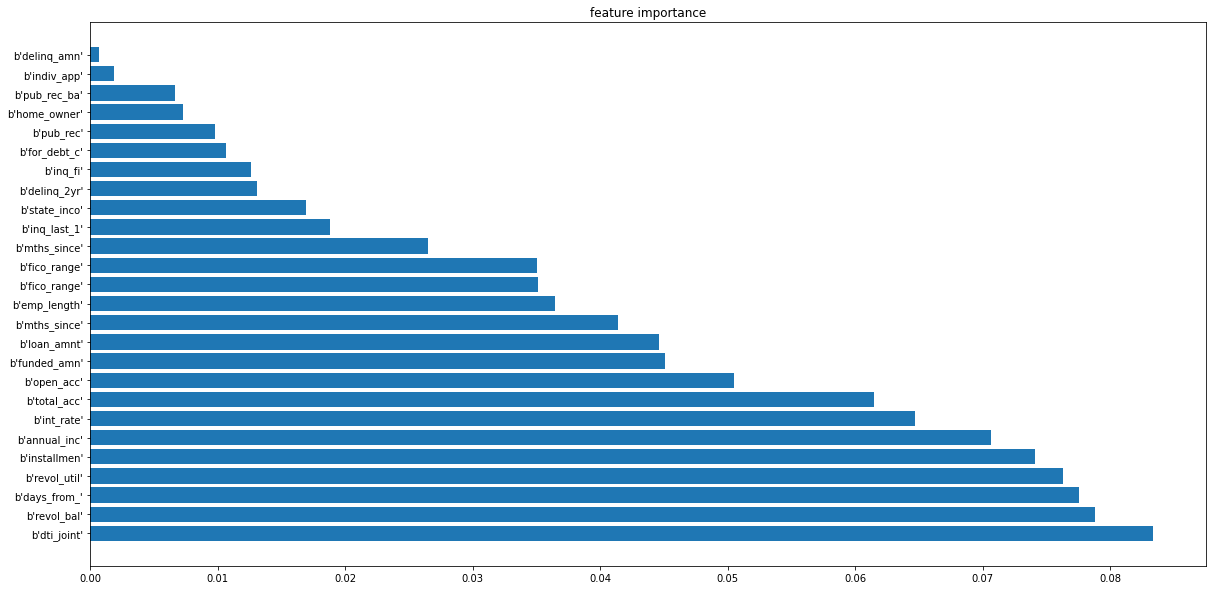

In [ ]:
plt.figure(figsize = (20,10))
featureNames, featureScores = zip(*list(feature_sort))
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.title('feature importance')

XGBoost time

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbm = GradientBoostingClassifier(random_state = 0)

In [ ]:
param_grid = {
    "learning_rate" : [0.001, 0.1, 1],
    "max_depth"     : [3, 5, 10],
    "subsample"     : [0.1, 0.9, 1],
    "n_estimators"  : [100]
}

In [ ]:
sample(data)

In [ ]:
%%time
grid_search_gbm = ms.GridSearchCV(gbm, param_grid, scoring = 'accuracy', cv = 2, n_jobs = -1)
grid_search_gbm.fit(, )

CPU times: user 4min 56s, sys: 866 ms, total: 4min 57s
Wall time: 49min 21s


In [ ]:
grid_search_gbm.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}

In [ ]:
grid_search_gbm.best_score_

0.7496403986437892

In [ ]:
confusion_matrix(y_true = y_test, y_pred = grid_search_gbm.best_estimator_.predict(X_test))

array([[86882,   518],
       [28772,   624]])

In [ ]:
print("The training score is: %.5f" % (grid_search_gbm.best_estimator_.score(X_train, y_train)))
print("The test     score is: %.5f" % (grid_search_gbm.best_estimator_.score(X_test, y_test)))

The training score is: 0.75075
The test     score is: 0.74922


Second Try at Gradient Boosting

In [ ]:
param_grid = {
    "learning_rate" : [0.01, 0.1],
    "max_depth"     : [5],
    "subsample"     : [0.9],
    "n_estimators"  : [100, 200, 300]
}

In [ ]:
%%time
grid_search_gbm = ms.GridSearchCV(gbm, param_grid, scoring = 'accuracy', cv = 3, n_jobs = -1)
grid_search_gbm.fit(, )

In [ ]:
grid_search_gbm.best_params_

In [ ]:
grid_search_gbm.best_score_

Support Vector Machines

In [ ]:
from sklearn.svm import SVC

In [ ]:
%%time 
svm = SVC(class_weight = class_weight, random_state = 0, )
svm.fit(X_train, y_train)
print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))
confusion_matrix(y_true = y_test, y_pred = grid_search_gbm.best_estimator_.predict(X_test))